# Conversational RAG
In many Q&A applications we want to allow the user to have a back-and-forth conversation, meaning the application needs some sort of "memory" of past questions and answers, and some logic for incorporating those into its current thinking.

In this guide we focus on adding logic for incorporating historical messages. Further details on chat history management is covered here.

We will cover two approaches:

Chains, in which we always execute a retrieval step;
Agents, in which we give an LLM discretion over whether and how to execute a retrieval step (or multiple steps).
For the external knowledge source, we will use the same LLM Powered Autonomous Agents blog post by Lilian Weng from the RAG tutorial.

## Chains
Let's first revisit the Q&A app we built over the LLM Powered Autonomous Agents blog post by Lilian Weng in the RAG tutorial.

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [2]:
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [3]:
# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()


# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [4]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

'Task decomposition is a method of breaking down complex tasks into smaller, more manageable steps. This approach helps agents or models tackle difficult problems by dividing them into simpler subtasks. Techniques like Chain of Thought and Tree of Thoughts are used to guide the decomposition process and enhance performance on complex tasks.'

### Adding chat history
The chain we have built uses the input query directly to retrieve relevant context. But in a conversational setting, the user query might require conversational context to be understood. For example, consider this exchange:

Human: "What is Task Decomposition?"

AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."

Human: "What are common ways of doing it?"

In order to answer the second question, our system needs to understand that "it" refers to "Task Decomposition."

We'll need to update two things about our existing app:

Prompt: Update our prompt to support historical messages as an input.
Contextualizing questions: Add a sub-chain that takes the latest user question and reformulates it in the context of the chat history. This can be thought of simply as building a new "history aware" retriever. Whereas before we had:
query -> retriever
Now we will have:
(query, conversation history) -> LLM -> rephrased query -> retriever
Contextualizing the question
First we'll need to define a sub-chain that takes historical messages and the latest user question, and reformulates the question if it makes reference to any information in the historical information.

We'll use a prompt that includes a MessagesPlaceholder variable under the name "chat_history". This allows us to pass in a list of Messages to the prompt using the "chat_history" input key, and these messages will be inserted after the system message and before the human message containing the latest question.

Note that we leverage a helper function create_history_aware_retriever for this step, which manages the case where chat_history is empty, and otherwise applies prompt | llm | StrOutputParser() | retriever in sequence.

create_history_aware_retriever constructs a chain that accepts keys input and chat_history as input, and has the same output schema as a retriever.

In [5]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [6]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

- 1つ目のPrompt: "What is Task Decomposition?"
- 2つ目のPrompt: "What are common ways of doing it?"

In [7]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are common ways of doing it?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Task decomposition can be achieved through various methods, such as using prompting with language models like LLMs, providing task-specific instructions tailored to the nature of the task (e.g., writing a novel), or incorporating human inputs to guide the decomposition process. These approaches help break down complex tasks into smaller steps, enabling agents to plan and execute tasks more effectively.


#### Stateful management of chat history
Here we've gone over how to add application logic for incorporating historical outputs, but we're still manually updating the chat history and inserting it into each input. In a real Q&A application we'll want some way of persisting chat history and some way of automatically inserting and updating it.

For this we can use:

BaseChatMessageHistory: Store chat history.
RunnableWithMessageHistory: Wrapper for an LCEL chain and a BaseChatMessageHistory that handles injecting chat history into inputs and updating it after each invocation.
For a detailed walkthrough of how to use these classes together to create a stateful conversational chain, head to the How to add message history (memory) LCEL page.

Below, we implement a simple example of the second option, in which chat histories are stored in a simple dict. LangChain manages memory integrations with Redis and other technologies to provide for more robust persistence.

Instances of RunnableWithMessageHistory manage the chat history for you. They accept a config with a key ("session_id" by default) that specifies what conversation history to fetch and prepend to the input, and append the output to the same conversation history. Below is an example:

In [8]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [9]:
conversational_rag_chain.invoke(
    {"input": "What is Task Decomposition?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)["answer"]

'Task decomposition involves breaking down complex tasks into smaller and simpler steps to facilitate problem-solving and planning. Techniques like Chain of Thought and Tree of Thoughts help agents decompose tasks into manageable sub-tasks, enhancing their performance on challenging problems. Task decomposition can be achieved through various methods such as using language models with specific prompts, task-specific instructions, or human inputs.'

In [10]:
conversational_rag_chain.invoke(
    {"input": "What are common ways of doing it?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'Task decomposition can be commonly done using techniques such as prompting language models with specific instructions like "Steps for XYZ" or "What are the subgoals for achieving XYZ?", providing task-specific instructions like "Write a story outline" for writing a novel, or incorporating human inputs to break down complex tasks into manageable steps. These methods help in organizing thoughts and actions, leading to more efficient problem-solving and planning processes.'

Conversation Historyの中身

In [11]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition involves breaking down complex tasks into smaller and simpler steps to facilitate problem-solving and planning. Techniques like Chain of Thought and Tree of Thoughts help agents decompose tasks into manageable sub-tasks, enhancing their performance on challenging problems. Task decomposition can be achieved through various methods such as using language models with specific prompts, task-specific instructions, or human inputs.

User: What are common ways of doing it?

AI: Task decomposition can be commonly done using techniques such as prompting language models with specific instructions like "Steps for XYZ" or "What are the subgoals for achieving XYZ?", providing task-specific instructions like "Write a story outline" for writing a novel, or incorporating human inputs to break down complex tasks into manageable steps. These methods help in organizing thoughts and actions, leading to more efficient problem-solving and planning p

## Agents
Agents leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allow you to offload some discretion over the retrieval process. Although their behavior is less predictable than chains, they offer some advantages in this context:

Agents generate the input to the retriever directly, without necessarily needing us to explicitly build in contextualization, as we did above;
Agents can execute multiple retrieval steps in service of a query, or refrain from executing a retrieval step altogether (e.g., in response to a generic greeting from a user).

### Retrieval tool
Agents can access "tools" and manage their execution. In this case, we will convert our retriever into a LangChain tool to be wielded by the agent:

In [13]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]

In [14]:
tool.invoke("task decomposition")

'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The mode

### Agent constructor
Now that we have defined the tools and the LLM, we can create the agent. We will be using LangGraph to construct the agent. Currently we are using a high level interface to construct the agent, but the nice thing about LangGraph is that this high-level interface is backed by a low-level, highly controllable API in case you want to modify the agent logic.

In [15]:
from langgraph.prebuilt import chat_agent_executor

agent_executor = chat_agent_executor.create_tool_calling_executor(llm, tools)

LangGraphは可視化ができる  
このTutorialだと実験できないが、複雑な分岐とかがかけるのがLnagGraphの魅力っぽい。

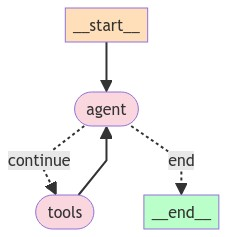

In [21]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph(xray=True).draw_mermaid_png()))

In [16]:
query = "What is Task Decomposition?"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xjIgEnVDKwL0qR5pKyVEdrxj', 'function': {'arguments': '{"query":"Task Decomposition"}', 'name': 'blog_post_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 68, 'total_tokens': 87}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a4f2d727-b509-45ad-bda7-54a62b87fbb9-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Task Decomposition'}, 'id': 'call_xjIgEnVDKwL0qR5pKyVEdrxj'}])]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performanc

Sqliteで会話履歴を持ってagent_executorを作るっぽい

In [17]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

agent_executor = chat_agent_executor.create_tool_calling_executor(
    llm, tools, checkpointer=memory
)

In [18]:
config = {"configurable": {"thread_id": "abc123"}}

for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Hi! I'm bob")]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 67, 'total_tokens': 78}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3f58fddf-0061-4b3c-a3ec-cfc7593cd2b0-0')]}}
----


In [19]:
query = "What is Task Decomposition?"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v9zxu8ijct1cRxFmhjkaaKOD', 'function': {'arguments': '{"query":"Task Decomposition"}', 'name': 'blog_post_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 91, 'total_tokens': 110}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-56b23f77-d146-4411-af3c-28265d0db853-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Task Decomposition'}, 'id': 'call_v9zxu8ijct1cRxFmhjkaaKOD'}])]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performan

In [20]:
query = "What according to the blog post are common ways of doing it? redo the search"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jj0ihnufRoKOuMeknt5dYNrV', 'function': {'arguments': '{"query":"Common ways of task decomposition"}', 'name': 'blog_post_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 792, 'total_tokens': 813}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f1cfb8c9-c778-4ef2-9c51-d0e599b0bbbe-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Common ways of task decomposition'}, 'id': 'call_jj0ihnufRoKOuMeknt5dYNrV'}])]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting techniqu